In [27]:
import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry import Polygon, LineString, Point
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Import top 20 cities by population file
urban_areas = gpd.read_file('/Users/lily/Documents/GitHub/parking_lots/states/20_cities.geojson')

# Create list of city names
ua_names = urban_areas['NAME10']
cities = []
for i in range(len(ua_names)):
    cities.append(ua_names[i])
cities

['Indianapolis,  Indiana',
 'Jacksonville, Florida',
 'Seattle, Washington',
 'Charlotte, North Carolina',
 'Houston, Texas',
 'Denver,  Colorado',
 'Columbus, Ohio',
 'San Francisco, California',
 'San Jose, California',
 'San Diego, California',
 'New York, New York',
 'Philadelphia, Pennsylvania',
 'Dallas, Texas',
 'El Paso, Texas',
 'Chicago, Illinois',
 'Los Angeles, California',
 'Phoenix, Arizona',
 'San Antonio, Texas',
 'Austin, Texas',
 'Washington, DC']

In [15]:
# Pop these indices in this order to correct the cities list -- 3,4,5,6,6,11,11,12,5
cities.pop(5)

'San Jose'

In [16]:
# Correct cities list to only contain the city names without the state attached
import re
city_names = []
for i in range(len(cities)):
    get_name = cities[i]
    fixed_name = re.sub(r',[^,]*$', '', get_name)
    city_names.append(fixed_name)
cities = city_names

In [18]:
def convert_wgs_to_utm(lon, lat):
    utm_band = str((math.floor((lon + 180) / 6 ) % 60) + 1)
    if len(utm_band) == 1:
        utm_band = '0'+utm_band
    if lat >= 0:
        epsg_code = '326' + utm_band
    else:
        epsg_code = '327' + utm_band
    return epsg_code

In [32]:
parking_percents = []
city_areas = []
parking_sums = []
for i in range(len(cities)):
    # Read city boundary and parking lot polygon files
    city = gpd.read_file('/Users/lily/Documents/GitHub/parking_lots/city_boundaries/' + cities[i].replace(' ', '_') + '_boundary.shp')
    parking_lots = gpd.read_file('/Users/lily/Documents/GitHub/parking_lots/parking_lots/' + cities[i].replace(' ', '_') + '_parking.shp')
    # Set CRS to WGS 84 (EPSG:4326)
    city_wgs = city.to_crs(4326)
    city_parking_wgs = parking_lots.to_crs(4326)
    # Identify city polygon coords
    coords = city_wgs.total_bounds #a tuple containing minx, miny, maxx, maxy values for the bounds of the series as a whole
    # Get UTM zone EPSG code of city
    long = coords[0]
    lat = coords[0]
    utm_zone = convert_wgs_to_utm(long, lat)
    epsg = 'EPSG:' + utm_zone
    # Correct CRS to relevant UTM
    city_utm = city_wgs.to_crs(epsg)
    parking_utm = city_parking_wgs.to_crs(epsg)
    # Calculate area of OSM city boundary
    city_area = city_utm.area
    city_areas.append(city_area)
    # Calculate areas (and area percents) of each parking lot and add column to geoseries
    parking_utm['area'] = parking_utm.area
    parking_utm['area_percent'] = (parking_utm['area'] / city_area) * 100
    # Calculate sum of parking lot areas
    parking_sum = np.sum(parking_utm['area'])
    parking_sums.append(parking_sum)
    # Calculate parking lot area of city as a percent of total city area
    parking_percent = (parking_sum / city_area) * 100
    # Add percent value to list
    parking_percents.append(parking_percent)
parking_percents

[0    3.477085
 dtype: float64,
 0    0.422643
 dtype: float64,
 0    1.103871
 dtype: float64,
 0    1.162967
 dtype: float64,
 0    2.30084
 dtype: float64,
 0    2.212235
 dtype: float64,
 0    0.877751
 dtype: float64,
 0    0.43033
 dtype: float64,
 0    2.625216
 dtype: float64,
 0    1.202591
 dtype: float64,
 0    1.732617
 dtype: float64]

In [21]:
for i in range(len(cities)):
    print(parking_percents[i], cities[i])

0    3.477085
dtype: float64 Indianapolis
0    0.422643
dtype: float64 Jacksonville
0    1.103871
dtype: float64 Seattle
0    1.162967
dtype: float64 Houston
0    2.30084
dtype: float64 Columbus
0    2.212235
dtype: float64 Philadelphia
0    0.877751
dtype: float64 Dallas
0    0.43033
dtype: float64 El Paso
0    2.625216
dtype: float64 Chicago
0    1.202591
dtype: float64 Los Angeles
0    1.732617
dtype: float64 Austin


In [33]:
parking_data = {'City Name': ['Indianapolis','Jacksonville','Seattle','Houston','Columbus','Philadelphia','Dallas','El Paso',
                             'Chicago','Los Angeles','Austin'], 
                'Parking Lot Cover (%)': [3.477085,0.422643,1.103871,1.162967,2.30084,2.212235,0.877751,0.43033,2.625216,
                                         1.202591,1.732617],
                'Parking Lot Area': [36274124.73819159, 9572264.539578095, 4118717.4989357283, 18471771.549984884,
                                     13393589.675041903, 8161922.90215688, 8768296.200081225, 2879966.469996631,
                                     15954450.792099228, 16371192.338857906, 12552220.82217376],
               'City Area': [1.043234e+09,2.264857e+09,3.731159e+08,1.588331e+09,5.821173e+08,3.689446e+08,9.989499e+08,
                            6.692453e+08,6.077386e+08,1.361327e+09,7.244660e+08]}

parking_df = pd.DataFrame(data=parking_data)
parking_df

,City Name,Parking Lot Cover (%),Parking Lot Area,City Area
0,Indianapolis,3.477085,3.627412e+07,1.043234e+09
1,Jacksonville,0.422643,9.572265e+06,2.264857e+09
2,Seattle,1.103871,4.118717e+06,3.731159e+08
3,Houston,1.162967,1.847177e+07,1.588331e+09
4,Columbus,2.300840,1.339359e+07,5.821173e+08
5,Philadelphia,2.212235,8.161923e+06,3.689446e+08
6,Dallas,0.877751,8.768296e+06,9.989499e+08
7,El Paso,0.430330,2.879966e+06,6.692453e+08
8,Chicago,2.625216,1.595445e+07,6.077386e+08
9,Los Angeles,1.202591,1.637119e+07,1.361327e+09


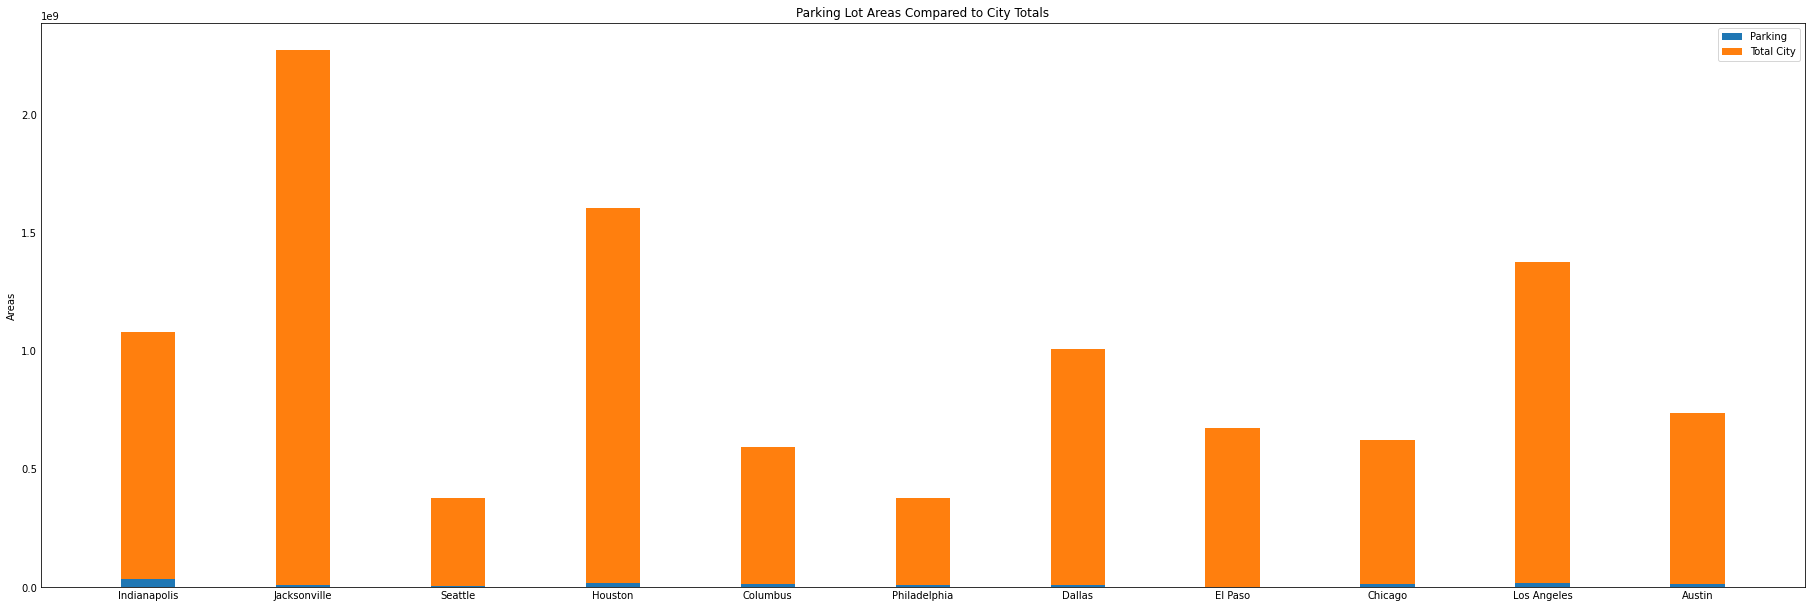

<Figure size 144x144 with 0 Axes>

In [43]:
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize = (25,8))

ax.bar(cities, parking_df['Parking Lot Area'], width, label='Parking')
ax.bar(cities, parking_df['City Area'], width, bottom=parking_df['Parking Lot Area'],
       label='Total City')

ax.set_ylabel('Areas')
ax.set_title('Parking Lot Areas Compared to City Totals')
ax.legend()

plt.show()
plt.savefig('/Users/lily/Documents/GitHub/parking_lots/figures/parking_city_bar_chart.png')